# 210712 Find max intra outliers

In [26]:
using Mmap

In [2]:
using JSON
using DataFrames
using FilePathsBase
using FilePathsBase: /
using Arrow
using HDF5
using PlotlyJS

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4180975106462005854\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5414650177540618666\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4180975106462005854\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [27]:
using Midas.Pairwise: npairs, iterpairs
using TriMatrices

## Setup

In [3]:
ENV["COLUMNS"] = 400
ENV["LINES"] = 100

100

In [4]:
DATESTR = "210715"
NBNAME = "$DATESTR-set-thresholds"

"210715-set-thresholds"

In [30]:
infiles = Dict(
    :distances => p"../../data/intermediate/200727-find-overlaps/genome-pw-distances.raw-float32",
#     :db => p"data-intermediate/210713-compile-edits/",
    :data => p"data-intermediate/210715-calculate-additional-data/",
);

## Load data

### Taxonomy

In [6]:
taxa = DataFrame(Arrow.Table(string(infiles[:data] / "taxa.arrow")));

In [7]:
genome_assignments = Vector{Int}(open(JSON.parse, infiles[:db] / "genome-assignments.json"))
ngenomes = length(genome_assignments)

50752

In [8]:
tid_to_tidx = Dict(id => i for (i, id) in enumerate(taxa[!, :id]))

taxon_index(tid::Integer) = tid_to_tidx[tid]
taxon_index(tids::AbstractVector{<:Integer}) = taxon_index.(tids)

lookup_tid(tid, cols=:) = taxa[taxon_index(tid), cols]

lookup_tid (generic function with 2 methods)

In [29]:
SUMMARY_COLS = [:id, :ncbi_id, :name, :rank, :parent_id, :in_v12, :manual_threshold, :report, :key, :is_leaf, :nleaves, :ngenomes, :diameter, :min_inter_src, :min_inter_dst, :min_inter_dist];

### Distances

In [31]:
pw_data = Mmap.mmap(open(infiles[:distances]), Vector{Float32}, (npairs(ngenomes),));

pw_dists = TriMatrix(TriSymmetric{false}(), ngenomes, pw_data);

## Plots

In [9]:
@assert !any(row.min_inter_dist <= row.manual_threshold for row in eachrow(taxa) if !isnan(row.manual_threshold))

In [39]:
taxa[!, :coverage_at_min_inter] = [
    count(<=(row.min_inter_dist), view(pw_dists, row.genomes, row.genomes)) / row.ngenomes ^ 2
    for row in eachrow(taxa)
];

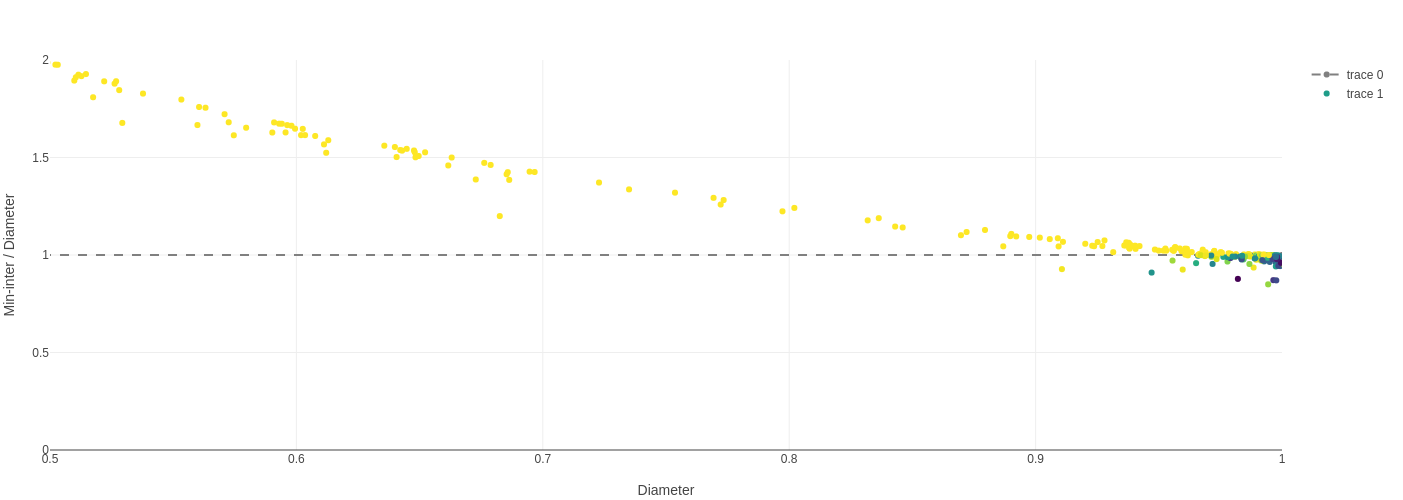

In [45]:
let
    inds = .!taxa.is_leaf .& isnan.(taxa.manual_threshold)
    
    traces = GenericTrace[]
    
    push!(traces, scatter(
        x=[0, 1],
        y=[1, 1],
        line=attr(
            color=:gray,
            dash=:dash,
        ),
    ))
    
    push!(traces, scatter(
        x=taxa[inds, :diameter],
        y=taxa[inds, :min_inter_dist] ./ taxa[inds, :diameter],
        text=taxa[inds, :plot_label],
        customdata=[
            [
                    row.min_inter_dist,
                    row.coverage_at_min_inter,
                    lookup_tid(row.min_inter_src, :plot_label),
                    lookup_tid(row.min_inter_dst, :plot_label),
            ]
            for row in eachrow(taxa[inds, :])
        ],
        mode=:markers,
        marker_color=coverage_at_min_inter[inds],
        marker_colorscale="Viridis",
        hovertemplate="(%{x:.3f}, %{customdata[0]:.3f}, %{customdata[1]:.1%})<br>%{text}<br>%{customdata[2]}<br>%{customdata[3]}<extra></extra>",
    ))
    
    layout = Layout(
        hovermode=:closest,
        xaxis=attr(
            title="Diameter",
            range=[0.5, 1.],
        ),
        yaxis=attr(
            title="Min-inter / Diameter",
            range=[0, 2],
        ),
        coloraxis=attr(
            colorscale="Viridis",
        ),
    )
    
    plot(traces, layout)
end

In [44]:
using MidasPlots.Plotly

In [46]:
margins = [0.00, 0.05, 0.10];

In [50]:
taxa[!, :base_threshold] = [isnan(row.manual_threshold) ? row.diameter : row.manual_threshold for row in eachrow(taxa)];

In [51]:
select_taxa_idxs = findall(taxa.min_inter_dist .* (1 - maximum(margins)) .<= taxa.base_threshold);
sort!(select_taxa_idxs, by=i -> ccj)
length(select_taxa_idxs)

252

In [ ]:
let
    ga = GridAxes(1, length(margins) + 1, sharey=true)
    
    let taxon = lookup_tid(1949)
        
    end
end